In [208]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 3000042069

In [209]:
dataset = 'model/skelett_history_classifier/skelett_history.csv'
model_save_path = 'model/skelett_history_classifier/skelett_history_classifier.hdf5.keras'
tflite_save_path = 'model/skelett_history_classifier/skelett_history_classifier.tflite'

In [210]:
NUM_CLASSES = 10

In [211]:
TIME_STEPS = 16
NUM_POINTS = 21 
DIMENSION = 2 * NUM_POINTS 

In [212]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [213]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.60, random_state=RANDOM_SEED)

In [215]:
use_lstm = True         ## Kanske ska var False, Behöver mer data då den är mer complex, LSTMs fördelar är att den är bättre på temporal dataset så tänker vi använder den
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [216]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 16, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 16)             │         3,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,056 (15.84 KB)

 Trainable params: 4,056 (15.84 KB)

 Non-trainable params: 0 (0.00 B)

In [217]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [218]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [219]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1090 - loss: 2.3341
Epoch 1: saving model to model/skelett_history_classifier/skelett_history_classifier.hdf5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1187 - loss: 2.3243 - val_accuracy: 0.1887 - val_loss: 2.2532
Epoch 2/1000
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1473 - loss: 2.2807 
Epoch 2: saving model to model/skelett_history_classifier/skelett_history_classifier.hdf5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1504 - loss: 2.2774 - val_accuracy: 0.1759 - val_loss: 2.2279
Epoch 3/1000
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1711 - loss: 2.2584 
Epoch 3: saving model to model/skelett_history_classifier/skelett_history_classifier.hdf5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1724 - loss: 2.2548 - val_accuracy: 0.1812 - val_loss: 2.2129
Epoch 4/1000
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1997 - loss: 2.2183 
Epoch 4: saving m

In [220]:
model = tf.keras.models.load_model(model_save_path)

In [221]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[1.2309712e-02 3.6273885e-04 1.2426561e-02 9.1601332e-04 5.0407834e-05
 1.4574979e-04 2.2169929e-03 3.6320495e-04 9.7120857e-01 1.5538517e-09]
8


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


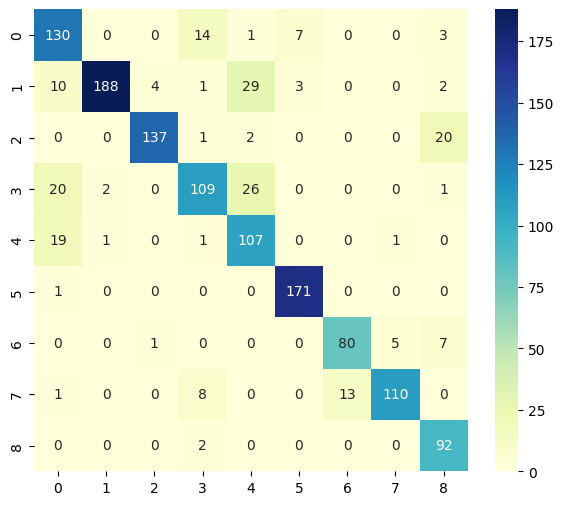

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       155
           1       0.98      0.79      0.88       237
           2       0.96      0.86      0.91       160
           3       0.80      0.69      0.74       158
           4       0.65      0.83      0.73       129
           5       0.94      0.99      0.97       172
           6       0.86      0.86      0.86        93
           7       0.95      0.83      0.89       132
           8       0.74      0.98      0.84        94

    accuracy                           0.85      1330
   macro avg       0.85      0.85      0.84      1330
weighted avg       0.86      0.85      0.85      1330



In [222]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, cmap='YlGnBu')
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [223]:
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [224]:
tflite_save_path = 'model/skelett_history_classifier/skelett_history_classifier.tflite'

In [225]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)  
# #converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quantized_model = converter.convert()

# open(tflite_save_path, 'wb').write(tflite_quantized_model)


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_quantized_model = converter.convert()
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)


INFO:tensorflow:Assets written to: C:\Users\jcull\AppData\Local\Temp\tmpdtqdgdw4\assets


INFO:tensorflow:Assets written to: C:\Users\jcull\AppData\Local\Temp\tmpdtqdgdw4\assets


Saved artifact at 'C:\Users\jcull\AppData\Local\Temp\tmpdtqdgdw4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 672), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2745476877968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2745476876240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2745325834448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2745325837328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2745325832912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2745325841168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2745325830800: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [226]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [227]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer_9:0', 'index': 0, 'shape': array([  1, 672], dtype=int32), 'shape_signature': array([ -1, 672], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [228]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [229]:
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [230]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.3297234e-02 3.8401908e-04 1.2833443e-02 8.7777356e-04 5.7779638e-05
 1.5889046e-04 2.0842776e-03 3.5879892e-04 9.6994781e-01 2.0006761e-09]
8
